## Setup

In [1]:
import os
import csv
import json
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_ranking as tfr

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
import glob
import librosa

In [3]:
import tensorflow_io as tfio

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-08-07 14:22:54.176577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-07 14:22:54.212906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 14:22:54.216511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 14:22:54.216898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

True

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)

In [5]:
data_dir_path = pathlib.Path('/home/jake/project/split')

In [6]:
aug = False

## Load Data

In [7]:
train_ds = tf.data.Dataset.list_files('/home/jake/project/split/train/*/*', shuffle=True)
test_ds = tf.data.Dataset.list_files('/home/jake/project/split/test/*/*', shuffle=True)
val_ds = tf.data.Dataset.list_files('/home/jake/project/split/val/*/*', shuffle=True)

2022-08-07 14:22:54.576602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 14:22:54.577065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 14:22:54.577439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 14:22:54.578255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 14:22:54.578747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [8]:
train_path = pathlib.Path('/home/jake/project/split/train/')

In [9]:
class_names = np.array(sorted([item.name for item in train_path.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['cough' 'laughter' 'sigh' 'sneeze' 'sniff' 'throatclearing']


## Define Data Pipeline Functions

In [10]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [11]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [12]:
def preprocess(file_path):
    label = get_label(file_path)
    wav = load_wav_16k_mono(file_path)
    #wav = wav[:67000]
    #zero_padding = tf.zeros([67000] - tf.shape(wav), dtype=tf.float32)
    wav = wav[:80000]
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    stfts = tf.signal.stft(wav, frame_length=1024 , frame_step=256)
    spectrograms = tf.abs(stfts)
    num_spectrogram_bins = 513
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000, 128
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
        linear_to_mel_weight_matrix.shape[-1:]))
    #mel_spectrograms.set_shape((256,256))
    log_mel_spec = tf.math.log(mel_spectrograms + 1e-6)
    #spectrogram = tf.expand_dims(spectrogram, axis=2)
    log_mel_spectrogram = tf.expand_dims(log_mel_spec, axis=2)
    return log_mel_spectrogram, label

### Test Data Pipeline

In [13]:
for x in train_ds.take(1):
    print(x.numpy())

b'/home/jake/project/split/train/sniff/m2144_0_sniff.wav'


In [14]:
test_path = '/home/jake/project/split/train/sigh/m0577_0_sigh.wav'

In [15]:
test_path = '/home/jake/project/split/train/sneeze/f3344_0_sneeze.wav'

In [16]:
test_path = '/home/jake/project/split/train/throatclearing/m1663_0_throatclearing.wav'

In [17]:
test_path = '/home/jake/project/split/train/laughter/m1231_0_laughter.wav'

In [18]:
spectrogram, label = preprocess(test_path)

2022-08-07 14:22:54.864936: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-08-07 14:22:55.438765: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


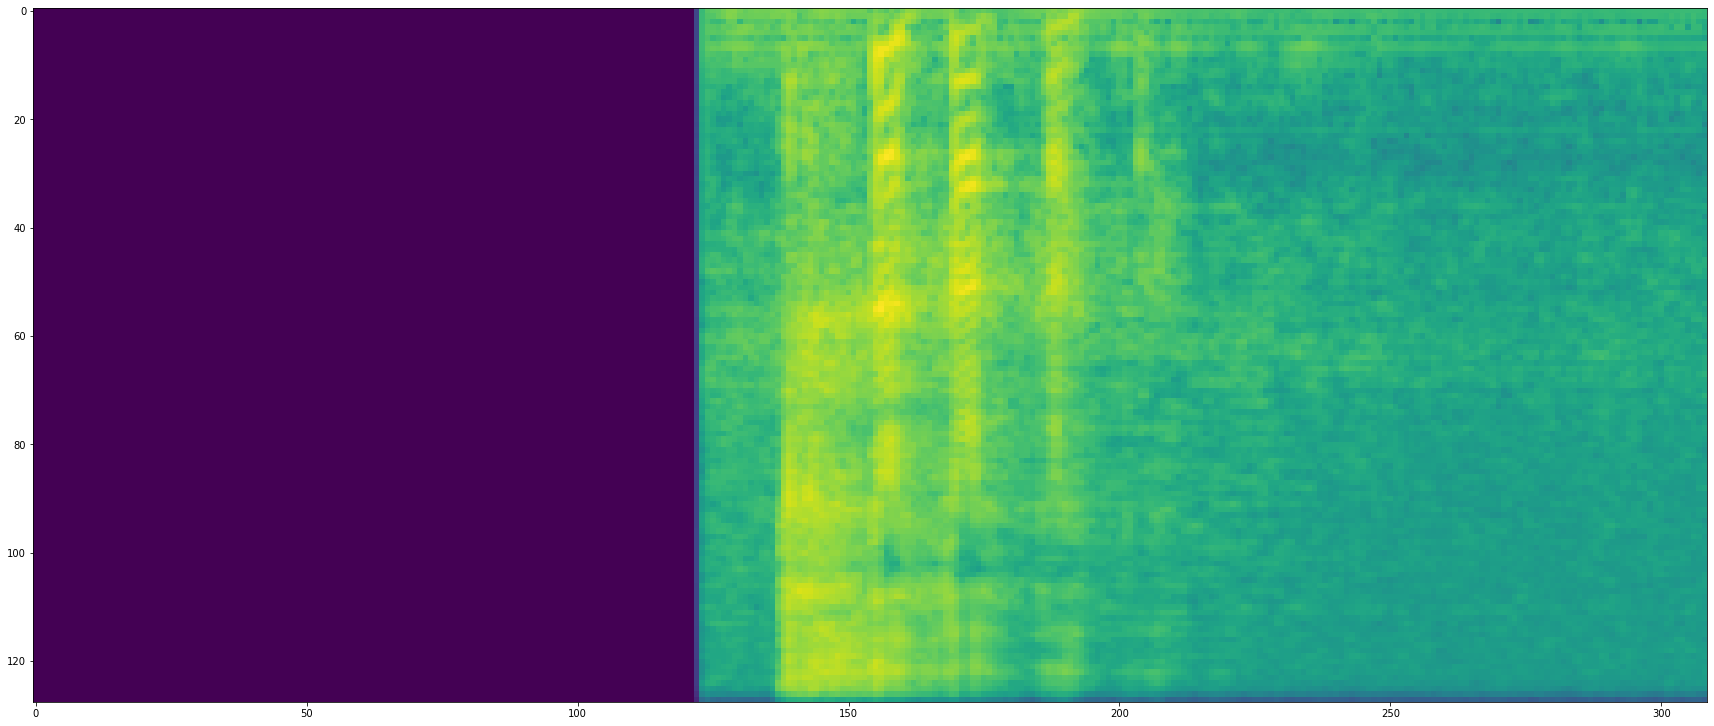

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Look at lengths of our spectrograms
#### We will use this to adjust zero paddding

In [20]:
look_at_lengths = False
if look_at_lengths == True:
    files = glob.glob('/home/jake/project/split/*/*/*')
    lengths = []
    for file in files:
        tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
        lengths.append(len(tensor_wave))
    print(tf.math.reduce_mean(lengths))
    print(tf.math.reduce_min(lengths))
    print(tf.math.reduce_max(lengths))

### Process Dataset

In [21]:
def configure_ds(dataset):
    dataset = dataset.map(preprocess)
    #dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(32)
    #dataset = dataset.prefetch(4)
    return dataset

In [22]:
train_ds = configure_ds(train_ds)
test_ds = configure_ds(test_ds)
val_ds = configure_ds(val_ds)

#### Look at shape of data in batch

In [23]:
samples, labels = train_ds.as_numpy_iterator().next()

In [24]:
samples.shape

(32, 309, 128, 1)

In [25]:
labels.shape

(32,)

In [26]:
specLen = samples.shape[1]

### Build Model

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#### set hyperparameters

In [28]:
learning_rate = 0.001
weight_decay = 0.0001
#batch_size = 16
num_epochs = 50
image_size = 144  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [29]:

import tensorflow as tf
from tensorflow.keras.layers import Layer


class SpecAugment(Layer):
    """
    Implementation of a layer that contains the SpecAugment Transformation
    """

    def __init__(self,
                 freq_mask_param: int,
                 time_mask_param: int,
                 n_freq_mask: int = 1,
                 n_time_mask: int = 1,
                 mask_value: float = 0.
                 ):
        """
        :param freq_mask_param: Frequency Mask Parameter (F in the paper)
        :param time_mask_param: Time Mask Parameter (T in the paper)
        :param n_freq_mask: Number of frequency masks to apply (mF in the paper). By default is 1.
        :param n_time_mask: Number of time masks to apply (mT in the paper). By default is 1.
        :param mask_value: Imputation value. By default is zero.
        """
        super(SpecAugment, self).__init__(name="SpecAugment")
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.n_freq_mask = n_freq_mask
        self.n_time_mask = n_time_mask
        self.mask_value = tf.cast(mask_value, tf.float32)

    def _frequency_mask_single(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        n_mels = tf.cast(tf.shape(input_mel_spectrogram)[1], tf.float32)
        freq_indices = tf.reshape(tf.cast(tf.range(n_mels), tf.int32), (1, -1, 1))

        # We use the paper's notation
        f = tf.cast(tf.random.uniform(shape=(), maxval=self.freq_mask_param), tf.int32)
        f0 = tf.cast(tf.random.uniform(shape=(), maxval=n_mels - tf.cast(f, tf.float32)), tf.int32)

        condition = tf.logical_and(freq_indices >= f0, freq_indices <= f0 + f)
        return tf.cast(condition, tf.float32)

    def _frequency_masks(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        mel_repeated = tf.repeat(tf.expand_dims(input_mel_spectrogram, 0), self.n_freq_mask, axis=0)
        masks = tf.cast(tf.map_fn(elems=mel_repeated, fn=self._frequency_mask_single), tf.bool)
        mask = tf.math.reduce_any(masks, 0)
        return tf.where(mask, self.mask_value, input_mel_spectrogram)

    def _time_mask_single(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        n_steps = tf.cast(tf.shape(input_mel_spectrogram)[0], tf.float32)
        time_indices = tf.reshape(tf.cast(tf.range(n_steps), tf.int32), (-1, 1, 1))

        # We use the paper's notation
        t = tf.cast(tf.random.uniform(shape=(), maxval=self.time_mask_param), tf.int32)
        t0 = tf.cast(tf.random.uniform(shape=(), maxval=n_steps - tf.cast(t, tf.float32)), tf.int32)

        condition = tf.logical_and(time_indices >= t0, time_indices <= t0 + t)
        return tf.cast(condition, tf.float32)

    def _time_masks(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        mel_repeated = tf.repeat(tf.expand_dims(input_mel_spectrogram, 0), self.n_time_mask, axis=0)
        masks = tf.cast(tf.map_fn(elems=mel_repeated, fn=self._time_mask_single), tf.bool)
        mask = tf.math.reduce_any(masks, 0)
        return tf.where(mask, self.mask_value, input_mel_spectrogram)

    def _apply_spec_augment(self, input_mel_spectrogram: tf.Tensor) -> tf.Tensor:
        """
        :param input_mel_spectrogram:
        :return:
        """
        if self.n_freq_mask >= 1:
            input_mel_spectrogram = self._frequency_masks(input_mel_spectrogram)
        if self.n_time_mask >= 1:
            input_mel_spectrogram = self._time_masks(input_mel_spectrogram)
        return input_mel_spectrogram

    def call(self, inputs: tf.Tensor, training=None, **kwargs):
        """
        Applies the SpecAugment operation to the input Mel Spectrogram
        :param inputs: The input mel spectrogram
        :param training: If True then it will be applied
        :return: A mel spectrogram after the time and frequency are applied
        """
        if training:
            inputs_masked = tf.map_fn(elems=inputs, fn=self._apply_spec_augment)
            return inputs_masked
        return inputs

    def get_config(self):
        """
        Generates a description of the parameters selected. It uses the notation in the paper
        :return:
        """
        config = {
            "freq_mask_param": self.freq_mask_param,
            "time_mask_param": self.time_mask_param,
            "n_freq_mask": self.n_freq_mask,
            "n_time_mask": self.n_time_mask,
            "mask_value": self.mask_value.numpy(),
        }
        return config

In [30]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)

In [31]:
spec_augment = SpecAugment(freq_mask_param=5,
                           time_mask_param=10,
                           n_freq_mask=5,
                           n_time_mask=3,
                           mask_value=-100) 

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

In [33]:
def create_cnn_classifier():
    model = Sequential()
    #model.add(layer.Input(shape=(311,128,1)))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(309, 128, 1)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()
    return model

In [35]:
def run_experiment(model):
    #optimizer = tfa.optimizers.AdamW(
    #    learning_rate=learning_rate, weight_decay=weight_decay
    #)

    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
            #keras.metrics.AUC(name='auc'),
            #tfa.metrics.F1Score(name='F1',num_classes=6)
        ],
    )

    cwd = os.getcwd()
    model_dir = os.path.join(cwd,'models')
    this_model_dir = os.path.join(model_dir,f'cnn')
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    if not os.path.exists(this_model_dir):
        os.mkdir(this_model_dir)
    checkpoint_filepath = os.path.join(this_model_dir,'cp.ckpt')
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_2_accuracy = model.evaluate(val_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")

    return history


cnn_classifier = create_cnn_classifier()
history = run_experiment(cnn_classifier)


Epoch 1/50


2022-08-07 14:23:05.821778: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-07 14:23:06.465795: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 14:23:06.466127: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 14:23:06.466136: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-07 14:23:06.466485: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-07 14:23:06.466520: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


486/486 [==============================] - 26s 49ms/step - loss: 0.9424 - accuracy: 0.6709 - top-2-accuracy: 0.8267 - val_loss: 0.5877 - val_accuracy: 0.8090 - val_top-2-accuracy: 0.9237
Epoch 2/50
486/486 [==============================] - 24s 48ms/step - loss: 0.5390 - accuracy: 0.8224 - top-2-accuracy: 0.9224 - val_loss: 0.4641 - val_accuracy: 0.8485 - val_top-2-accuracy: 0.9390
Epoch 3/50
486/486 [==============================] - 24s 48ms/step - loss: 0.4186 - accuracy: 0.8576 - top-2-accuracy: 0.9423 - val_loss: 0.4364 - val_accuracy: 0.8555 - val_top-2-accuracy: 0.9496
Epoch 4/50
486/486 [==============================] - 24s 48ms/step - loss: 0.3339 - accuracy: 0.8875 - top-2-accuracy: 0.9572 - val_loss: 0.4341 - val_accuracy: 0.8635 - val_top-2-accuracy: 0.9410
Epoch 5/50
486/486 [==============================] - 24s 48ms/step - loss: 0.2278 - accuracy: 0.9210 - top-2-accuracy: 0.9746 - val_loss: 0.4877 - val_accuracy: 0.8544 - val_top-2-accuracy: 0.9387
Epoch 6/50
486/486 [=

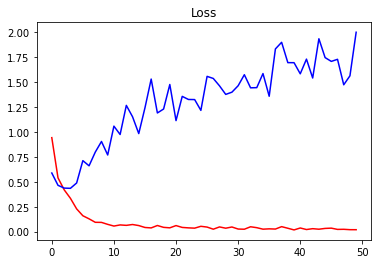

In [36]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

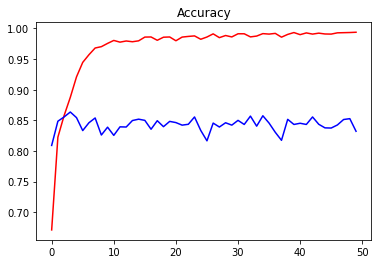

In [37]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.show()

### Output

In [38]:
import pickle
import csv

In [39]:
cwd = os.getcwd()
model_dir = os.path.join(cwd,'models')
this_model_dir = os.path.join(model_dir,f'cnn')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(this_model_dir):
    os.mkdir(this_model_dir)
with open(os.path.join(this_model_dir,'history.pkl'), 'wb') as f:
    pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)